In [7]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import sys
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns
import networkx as nx
from scipy.spatial import Delaunay
from tqdm import tqdm
from matplotlib.patches import Patch
from collections import Counter 
import seaborn as sns
from scipy.stats import zscore
from scipy.cluster import hierarchy
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
import pickle
import os 

## Load data

Load data and aggregate some of the annotations in to broader categories. 

In [8]:
annotation = pd.read_csv('../output/Scaled_data_121724/ROI.csv')

annotation.loc[annotation['Annotation'].str.contains('CD8'), 'Annotation'] = 'CD8 T'
annotation.loc[annotation['Annotation'].str.contains('CD4'), 'Annotation'] = 'CD4 T'
annotation.loc[annotation['Annotation'].str.contains('Tumor'), 'Annotation'] = 'Tumor'
annotation = annotation.loc[~annotation['Annotation'].isin(['Other', 'Neutrophil'])]
annotation = annotation.loc[~annotation['coreName'].str.contains('Tonsil')]

selected_cores =  ["Rochester_4", "Rochester_6",
                    "Rochester_7", "Rochester_9", "Rochester_11", "Rochester_12",
                    "Rochester_13", "Rochester_14",
                    "Rochester_15", "Rochester_16", "Rochester_17", "Rochester_18",
                    "Rochester_19", "Rochester_21", "Rochester_23", "Rochester_25",
                     "DFCI_2.2", "DFCI_3.2",
                    "DFCI_4.1", "DFCI_7.1", "DFCI_8.1",
                    "DFCI_12.1", "DFCI_13.2", "DFCI_14.1", "DFCI_15.2", "DFCI_17.1",
                    "DFCI_18.2", "DFCI_19.2", "DFCI_22.2", "DFCI_23.2"]

annotation = annotation.loc[annotation['coreName'].isin(selected_cores)]

annotation.loc[annotation['Annotation'].str.contains('M1'), 'Annotation'] = 'M1-like'
annotation.loc[annotation['Annotation'].str.contains('M2'), 'Annotation'] = 'M2-like'

Adding EBV status information

In [9]:
annotation['ebv_status'] = annotation['coreName'].apply(lambda x: 'Positive' if x in ["DFCI_1.2", "DFCI_2.2", "DFCI_3.2",
                         "DFCI_4.1", "DFCI_6.1", "DFCI_7.1", "DFCI_8.1", "DFCI_9.1", "DFCI_11.1",
                         "DFCI_12.1", "Rochester_4", "Rochester_5","Rochester_7",
                         "Rochester_9", "Rochester_10","Rochester_14", "Rochester_11", "Rochester_15",
                         "Rochester_16", "Rochester_17", "Rochester_18",  "Rochester_25"
                         ] else 'Negative') 

## Color palette for cell type

In [10]:
celltype_color = {"Tumor" : "#e51d1d", 
                      "CD8 T" : "#377eb8", 
                      "CD4 T" : "#4eaf49", 
                      "M1-like" : "#974da2", 
                      "M2-like" : "#ff8000", 
                      "DC" : "#83e3f0", 
                      "Endothelial" : "#c67f66", 
                      "Treg" : "#9ED900", 
                      "B cell" : "#e89ff0",
                    "Other": "#D3D3D3E6",
                    "Neutrophil": "#C85022"}

# Build graph

## Helper functions

`get_neighbors` returns the one-hop and two-hop neighbors for a given node. `within_threshold` detect if two nodes are within a given threshold. The default metric is Euclidean distance.

In [11]:
# Function to get one-hop and two-hop neighbors for a given node
def get_neighbors(graph, node):
    # Get one-hop neighbors
    one_hop_neighbors = list(graph.neighbors(node))
    
    # Get two-hop neighbors
    two_hop_neighbors = set()
    for neighbor in one_hop_neighbors:
        two_hop_neighbors.update(graph.neighbors(neighbor))
    
    # Remove the original node and one-hop neighbors from the two-hop neighbors
    two_hop_neighbors.discard(node)
    two_hop_neighbors.difference_update(one_hop_neighbors)
    
    return one_hop_neighbors, list(two_hop_neighbors)

def within_threshold(p1, p2, mpp, threshold = 100):
    distance = np.linalg.norm(p1 - p2) * mpp
    return (distance <= threshold)

Build graph. There are several outputs:

- images of the graph built
- One-hop, two-hop directory for each cell in all the cores. 
- The graph for each ROI and the count table for each ROI saved as `.pkl`.

In [13]:
graph_dict = {}

count_df_dict = {}

for core in tqdm(annotation['coreName'].unique()):
    print(f'Working on {core}...')
    # Create a new figure for each core
    fig, ax = plt.subplots(figsize=(20, 20))

    # subset data
    sub_df = annotation.loc[annotation['coreName'] == core] 
    sub_df = sub_df.loc[~sub_df['Annotation'].isin(['Neutrophil', 'Other'])]
    pts = sub_df.loc[:,['X_cent_fusion', 'Y_cent_fusion']].values
    sub_df_reindex = sub_df.reset_index(drop = True)

    # Delaunay triangulation
    tri = Delaunay(points = pts)
    
    # Create a graph from the triangulation
    G = nx.Graph()
    G.add_nodes_from(range(len(pts)))
    MPP = 0.5 # micron per pixel
    THRESHOLD = 20 # only connect nodes if they are within 50um of each other 
    for simplex in tri.simplices:
        if within_threshold(pts[simplex[0]], pts[simplex[1]], mpp = MPP, threshold = THRESHOLD):
            G.add_edge(simplex[0], simplex[1])
        if within_threshold(pts[simplex[1]], pts[simplex[2]], mpp = MPP, threshold = THRESHOLD):
            G.add_edge(simplex[1], simplex[2])
        if within_threshold(pts[simplex[2]], pts[simplex[0]], mpp = MPP, threshold = THRESHOLD):
            G.add_edge(simplex[2], simplex[0])
    print(f'Nodes in Graph match rows in dataframe: {G.number_of_nodes() == sub_df.shape[0]}')

    # append graph to graph dict

    graph_dict[core] = G

    # position of the nodes for plotting
    pos = dict(zip(range(len(pts)), pts))

    # Convert positions to a numpy array for easy transformation
    pos_array = np.array([coords for coords in pos.values()])

    # Reflect the graph about the x-axis (flip y-coordinates)
    reflected_array = pos_array * [1, -1]

    # Create a new position dictionary from the reflected array
    reflected_pos = dict(zip(pos.keys(), reflected_array))

    output = '../output/hop_analysis_121724/graph_20um'

    os.makedirs(output, exist_ok=True)

    # Create a list of colors for each node based on its annotation
    node_colors = [celltype_color[annotation] for annotation in sub_df['Annotation']]

    # plot the graph
    nx.draw_networkx_nodes(G, pos=reflected_pos, node_size=20, node_color=node_colors, ax=ax)
    nx.draw_networkx_edges(G, pos=reflected_pos, edge_color='gray', alpha=0.5, ax=ax)
    
    # Create legend
    legend_handles = []
    legend_labels = []

    # Iterate over the cell types and colors present in this core
    for celltype in sub_df['Annotation'].unique():
        color = celltype_color[celltype]
        # Create a Patch for each cell type
        patch = Patch(color=color, label=celltype)
        legend_handles.append(patch)
        legend_labels.append(celltype)

    # Create the legend
    ax.legend(handles=legend_handles, labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')

    ax.set_title(f'Cell Graph for Core: {core}')
    ax.axis('equal')
    ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'../output/hop_analysis_121724/graph_20um/{core}.png')
    plt.close()

    # Create a dict to store the 1-hop, 2-hop neighbors

    neighbors_dict = {}

    for node in G.nodes():
        neighbors_dict[node] = {}
        one_hop, two_hop = get_neighbors(G, node)
        neighbors_dict[node]['one hop'] = one_hop
        neighbors_dict[node]['two hop'] = two_hop

    cellLabel_neighbors_dict = {}

    for key, item in neighbors_dict.items():
        new_key = sub_df_reindex['cellLabel'][key]
        cellLabel_neighbors_dict[new_key] = {}
        one_hop_cellLabel = str(sub_df_reindex['cellLabel'][item['one hop']].values)
        two_hop_cellLabel = str(sub_df_reindex['cellLabel'][item['two hop']].values)
        cellLabel_neighbors_dict[new_key]['one hop'] = one_hop_cellLabel
        cellLabel_neighbors_dict[new_key]['two hop'] = two_hop_cellLabel


    LUT_df = pd.DataFrame([(key, item['one hop'], item['two hop']) for key, item in cellLabel_neighbors_dict.items()],
                                columns=['cellLabel', 'one_hop', 'two_hop'])
    
    output = '../output/hop_analysis_121724/LUT_ROI'

    os.makedirs(output, exist_ok=True)

    LUT_df.to_csv(f'{output}/{core}.csv', index=False)

    # Anchor on each celltype and check its neighbors

    count_df_dict[core] = {}

    for i in sub_df_reindex['Annotation'].unique():
        idx = sub_df_reindex[sub_df_reindex['Annotation'] == i].index
        celltype_df = sub_df_reindex.iloc[idx]
        count_df_dict[core][i] = {}
        count_dict_one_hop = {}
        count_dict_two_hop = {}
        count_dict_one_and_two = {}
        for j in idx:
            one_hop = neighbors_dict[j]['one hop']
            two_hop = neighbors_dict[j]['two hop']
            
            j_df_one_hop = sub_df_reindex['Annotation'][one_hop]
            iter_counts_one_hop = Counter(j_df_one_hop)
            count_dict_one_hop[sub_df_reindex['cellLabel'][j]] = iter_counts_one_hop
            
            j_df_two_hop = sub_df_reindex['Annotation'][two_hop]
            iter_counts_two_hop = Counter(j_df_two_hop)
            count_dict_two_hop[sub_df_reindex['cellLabel'][j]] = iter_counts_two_hop

            j_df_one_and_two = sub_df_reindex['Annotation'][[i for i in one_hop + two_hop]]
            iter_counts_one_and_two = Counter(j_df_one_and_two)
            count_dict_one_and_two[sub_df_reindex['cellLabel'][j]] = iter_counts_one_and_two
        count_df_one_hop = pd.DataFrame(count_dict_one_hop).transpose().fillna(0)
        count_df_two_hop = pd.DataFrame(count_dict_two_hop).transpose().fillna(0)
        count_df_one_and_two = pd.DataFrame(count_dict_one_and_two).transpose().fillna(0)

        count_df_dict[core][i]['one_hop'] = count_df_one_hop
        count_df_dict[core][i]['two_hop'] = count_df_two_hop
        count_df_dict[core][i]['one_and_two'] = count_df_one_and_two

with open('../output/hop_analysis_121724/count_df_dict_ROI.pkl', 'wb') as handle:
    pickle.dump(count_df_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../output/hop_analysis_121724/graph_dict_ROI.pkl', 'wb') as handle:
    pickle.dump(graph_dict, handle, protocol=pickle.HIGHEST_PROTOCOL) 

    
    








  0%|          | 0/30 [00:00<?, ?it/s]

Working on DFCI_4.1...
Nodes in Graph match rows in dataframe: True


  3%|▎         | 1/30 [00:10<05:17, 10.94s/it]

Working on DFCI_8.1...
Nodes in Graph match rows in dataframe: True


  7%|▋         | 2/30 [00:16<03:42,  7.96s/it]

Working on DFCI_13.2...
Nodes in Graph match rows in dataframe: True


 10%|█         | 3/30 [00:26<04:00,  8.90s/it]

Working on DFCI_15.2...
Nodes in Graph match rows in dataframe: True


 13%|█▎        | 4/30 [00:32<03:22,  7.80s/it]

Working on DFCI_17.1...
Nodes in Graph match rows in dataframe: True


 17%|█▋        | 5/30 [00:43<03:35,  8.64s/it]

Working on DFCI_18.2...
Nodes in Graph match rows in dataframe: True


 20%|██        | 6/30 [00:56<04:04, 10.18s/it]

Working on DFCI_19.2...
Nodes in Graph match rows in dataframe: True


 23%|██▎       | 7/30 [01:08<04:10, 10.89s/it]

Working on DFCI_22.2...
Nodes in Graph match rows in dataframe: True


 27%|██▋       | 8/30 [01:18<03:53, 10.61s/it]

Working on DFCI_12.1...
Nodes in Graph match rows in dataframe: True


 30%|███       | 9/30 [01:25<03:16,  9.38s/it]

Working on DFCI_14.1...
Nodes in Graph match rows in dataframe: True


 33%|███▎      | 10/30 [01:29<02:34,  7.71s/it]

Working on DFCI_2.2...
Nodes in Graph match rows in dataframe: True


 37%|███▋      | 11/30 [01:38<02:36,  8.26s/it]

Working on DFCI_3.2...
Nodes in Graph match rows in dataframe: True


 40%|████      | 12/30 [01:45<02:23,  7.95s/it]

Working on DFCI_7.1...
Nodes in Graph match rows in dataframe: True


 43%|████▎     | 13/30 [01:54<02:20,  8.27s/it]

Working on DFCI_23.2...
Nodes in Graph match rows in dataframe: True


 47%|████▋     | 14/30 [02:02<02:07,  7.99s/it]

Working on Rochester_4...
Nodes in Graph match rows in dataframe: True


 50%|█████     | 15/30 [02:17<02:32, 10.14s/it]

Working on Rochester_6...
Nodes in Graph match rows in dataframe: True


 53%|█████▎    | 16/30 [02:26<02:16,  9.73s/it]

Working on Rochester_11...
Nodes in Graph match rows in dataframe: True


 57%|█████▋    | 17/30 [02:37<02:10, 10.07s/it]

Working on Rochester_12...
Nodes in Graph match rows in dataframe: True


 60%|██████    | 18/30 [02:43<01:46,  8.92s/it]

Working on Rochester_14...
Nodes in Graph match rows in dataframe: True


 63%|██████▎   | 19/30 [02:51<01:34,  8.59s/it]

Working on Rochester_18...
Nodes in Graph match rows in dataframe: True


 67%|██████▋   | 20/30 [03:02<01:34,  9.45s/it]

Working on Rochester_19...
Nodes in Graph match rows in dataframe: True


 70%|███████   | 21/30 [03:14<01:31, 10.13s/it]

Working on Rochester_21...
Nodes in Graph match rows in dataframe: True


 73%|███████▎  | 22/30 [03:24<01:21, 10.23s/it]

Working on Rochester_23...
Nodes in Graph match rows in dataframe: True


 77%|███████▋  | 23/30 [03:35<01:13, 10.48s/it]

Working on Rochester_13...
Nodes in Graph match rows in dataframe: True


 80%|████████  | 24/30 [03:46<01:03, 10.66s/it]

Working on Rochester_15...
Nodes in Graph match rows in dataframe: True


 83%|████████▎ | 25/30 [03:56<00:51, 10.26s/it]

Working on Rochester_17...
Nodes in Graph match rows in dataframe: True


 87%|████████▋ | 26/30 [04:06<00:40, 10.19s/it]

Working on Rochester_25...
Nodes in Graph match rows in dataframe: True


 90%|█████████ | 27/30 [04:15<00:29,  9.84s/it]

Working on Rochester_7...
Nodes in Graph match rows in dataframe: True


 93%|█████████▎| 28/30 [04:28<00:21, 10.78s/it]

Working on Rochester_16...
Nodes in Graph match rows in dataframe: True


 97%|█████████▋| 29/30 [04:38<00:10, 10.47s/it]

Working on Rochester_9...
Nodes in Graph match rows in dataframe: True


100%|██████████| 30/30 [04:44<00:00,  9.47s/it]


Anchor on CD4 T cell and check the counts for its one-hop and two-hop neighbors.

In [14]:
cell_ls = []
for core in annotation['coreName'].unique():
    df = pd.concat([count_df_dict[core]['CD4 T']['one_hop']])
    cell_ls.append(df)

cell_count = pd.concat(cell_ls).fillna(0)
cell_ls_two_hop = []
for core in annotation['coreName'].unique():
    df = pd.concat([count_df_dict[core]['CD4 T']['two_hop']])
    cell_ls_two_hop.append(df)
cell_count_two_hop = pd.concat(cell_ls_two_hop).fillna(0)

cell_ls_one_and_two = []
for core in annotation['coreName'].unique():
    df = pd.concat([count_df_dict[core]['CD4 T']['one_and_two']])
    cell_ls_one_and_two.append(df)
cell_count_one_and_two = pd.concat(cell_ls_one_and_two).fillna(0)


## MiniBatchKMeans

### 1-hop

Elbow plot to determine K for K-means.

100%|██████████| 28/28 [00:10<00:00,  2.63it/s]


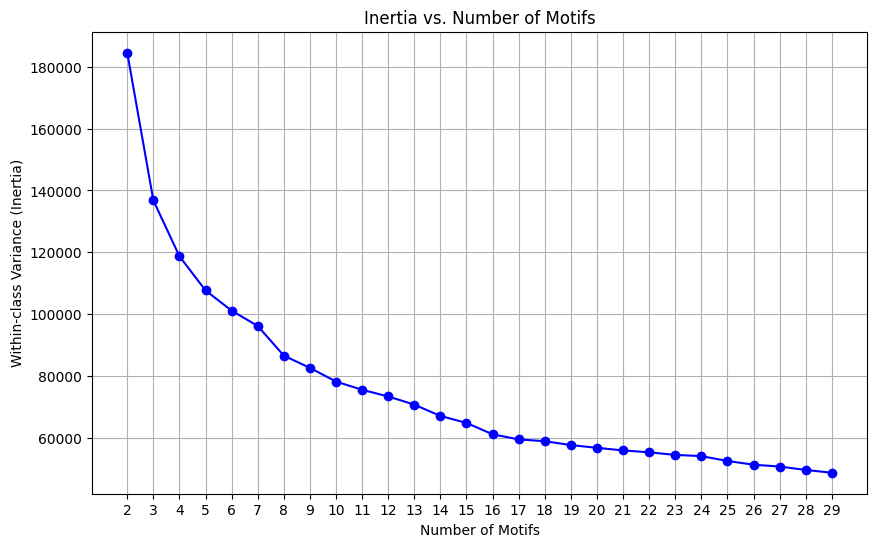

In [15]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Define the range of n_neighborhoods to test
n_neighborhoods_range = range(2, 30)  # Testing from 2 to 10 clusters
inertias = []

# Loop through different n_neighborhoods
for n in tqdm(n_neighborhoods_range):
    km = MiniBatchKMeans(n_clusters=n, random_state=12345)
    km.fit(cell_count.iloc[:,[0,1,2,3,4,5,6,7]].values)
    inertias.append(km.inertia_)

# Plot the inertias (within-class variances)
plt.figure(figsize=(10, 6))
plt.plot(n_neighborhoods_range, inertias, 'bo-')
plt.xlabel('Number of Motifs')
plt.ylabel('Within-class Variance (Inertia)')
plt.title('Inertia vs. Number of Motifs')
plt.xticks(n_neighborhoods_range)
plt.grid(True)
plt.savefig('../output/hop_analysis_121724/1_hop_elbow_seed12345_ROI.pdf')

K-means clustering.

Suggested optimal number of clusters: 5
Please inspect the elbow plot to confirm or adjust this value.


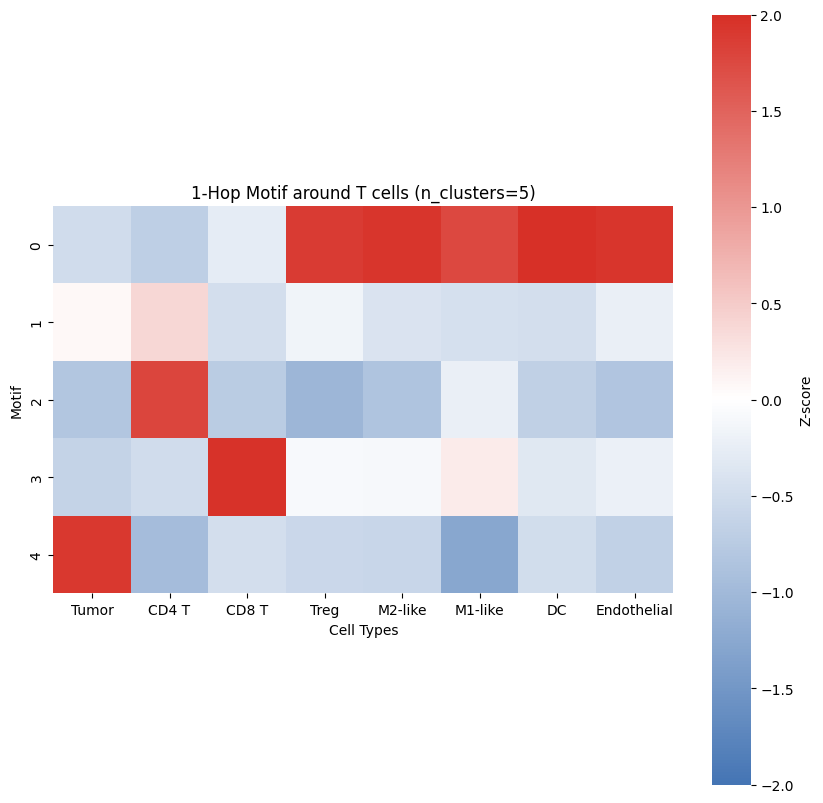

In [17]:
# Define the desired order of cell types
cell_type_order = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 5
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=12345)

labelskm = km.fit_predict(cell_count.iloc[:,[0,1,2,3,4,5,6,7]].values)
cell_count['Niche'] = labelskm

grouped_df = cell_count.iloc[:,[0,1,2,3,4,5,6,7,8]].groupby('Niche').mean()
z_scores = grouped_df.apply(zscore)

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Z-score'}, vmin=-2, vmax=2, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1-Hop Motif around T cells (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
plt.savefig('../output/hop_analysis_121724/heatmap/1_hop_motif_z_ROI.pdf')
plt.show()

In [45]:
cell_count

,Tumor,CD4 T,CD8 T,M1-like,Treg,DC,M2-like,Endothelial,Niche
1918,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1
2345,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3
2595,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2
2822,0.0,2.0,3.0,0.0,1.0,1.0,1.0,0.0,2
2834,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...
18214,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,1
18288,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0
18486,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0
18622,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1


In [19]:
df_ls = []

for core in tqdm(annotation['coreName'].unique()):
    print(f'Working on {core}...')
    # Create a new figure for each core
    #fig, ax = plt.subplots(figsize=(20, 20))

    # subset data
    sub_df = annotation.loc[annotation['coreName'] == core] 
    sub_df = sub_df.loc[~sub_df['Annotation'].isin(['Neutrophil', 'Other'])]
    pts = sub_df.loc[:,['X_cent_fusion', 'Y_cent_fusion']].values
    sub_df_reindex = sub_df.reset_index(drop = True)


    idx = sub_df_reindex[sub_df_reindex['Annotation'] == 'CD4 T'].index

    coreName = sub_df_reindex['coreName'].iloc[idx]
    cellLabel = sub_df_reindex['cellLabel'].iloc[idx]
    Annotation = sub_df_reindex['Annotation'].iloc[idx]

    output_df = pd.concat([coreName, cellLabel, Annotation], axis = 1)

    df_ls.append(output_df)

 37%|███▋      | 11/30 [00:00<00:00, 104.74it/s]

Working on DFCI_4.1...
Working on DFCI_8.1...
Working on DFCI_13.2...
Working on DFCI_15.2...
Working on DFCI_17.1...
Working on DFCI_18.2...
Working on DFCI_19.2...
Working on DFCI_22.2...
Working on DFCI_12.1...
Working on DFCI_14.1...
Working on DFCI_2.2...
Working on DFCI_3.2...
Working on DFCI_7.1...
Working on DFCI_23.2...
Working on Rochester_4...
Working on Rochester_6...
Working on Rochester_11...
Working on Rochester_12...
Working on Rochester_14...
Working on Rochester_18...
Working on Rochester_19...
Working on Rochester_21...


100%|██████████| 30/30 [00:00<00:00, 103.29it/s]

Working on Rochester_23...
Working on Rochester_13...
Working on Rochester_15...
Working on Rochester_17...
Working on Rochester_25...
Working on Rochester_7...
Working on Rochester_16...
Working on Rochester_9...


In [20]:
cellLabel_coreName_df = pd.concat(df_ls)

cellLabel_coreName_niche_df = pd.concat([cellLabel_coreName_df.reset_index(drop=True), cell_count.reset_index(drop=True)], axis = 1)

In [21]:
cellLabel_coreName_niche_df

,coreName,cellLabel,Annotation,Tumor,CD4 T,CD8 T,M1-like,Treg,M2-like,DC,Endothelial,Niche
0,DFCI_4.1,1918,CD4 T,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1
1,DFCI_4.1,2345,CD4 T,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4
2,DFCI_4.1,2595,CD4 T,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,3
3,DFCI_4.1,2822,CD4 T,0.0,2.0,3.0,0.0,1.0,1.0,1.0,0.0,3
4,DFCI_4.1,2834,CD4 T,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
33084,Rochester_9,18214,CD4 T,1.0,3.0,1.0,0.0,2.0,0.0,0.0,0.0,1
33085,Rochester_9,18288,CD4 T,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0
33086,Rochester_9,18486,CD4 T,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0
33087,Rochester_9,18622,CD4 T,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0


In [22]:
cellLabel_coreName_niche_df.to_csv('../output/hop_analysis_121724/cellLabel_coreName_niche_one_hop_count.csv', index=False)

In [57]:
tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'].isin(['CD4 T', 'CD8 T'])].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'].isin(['CD4 T', 'CD8 T'])].iterrows()]})

tumor_coreName_ebv

,coreName,ebv_status
0,DFCI_4.1,Positive
1,DFCI_4.1,Positive
2,DFCI_4.1,Positive
3,DFCI_4.1,Positive
4,DFCI_4.1,Positive
...,...,...
79948,Rochester_9,Positive
79949,Rochester_9,Positive
79950,Rochester_9,Positive
79951,Rochester_9,Positive


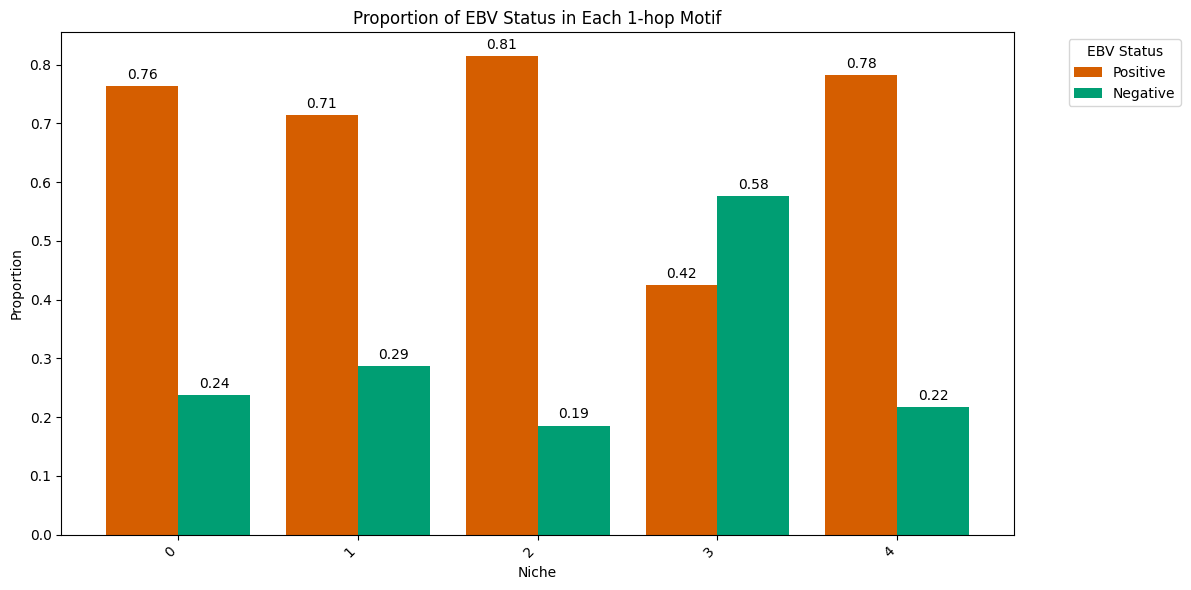

/opt/miniconda3/envs/cellSeg/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


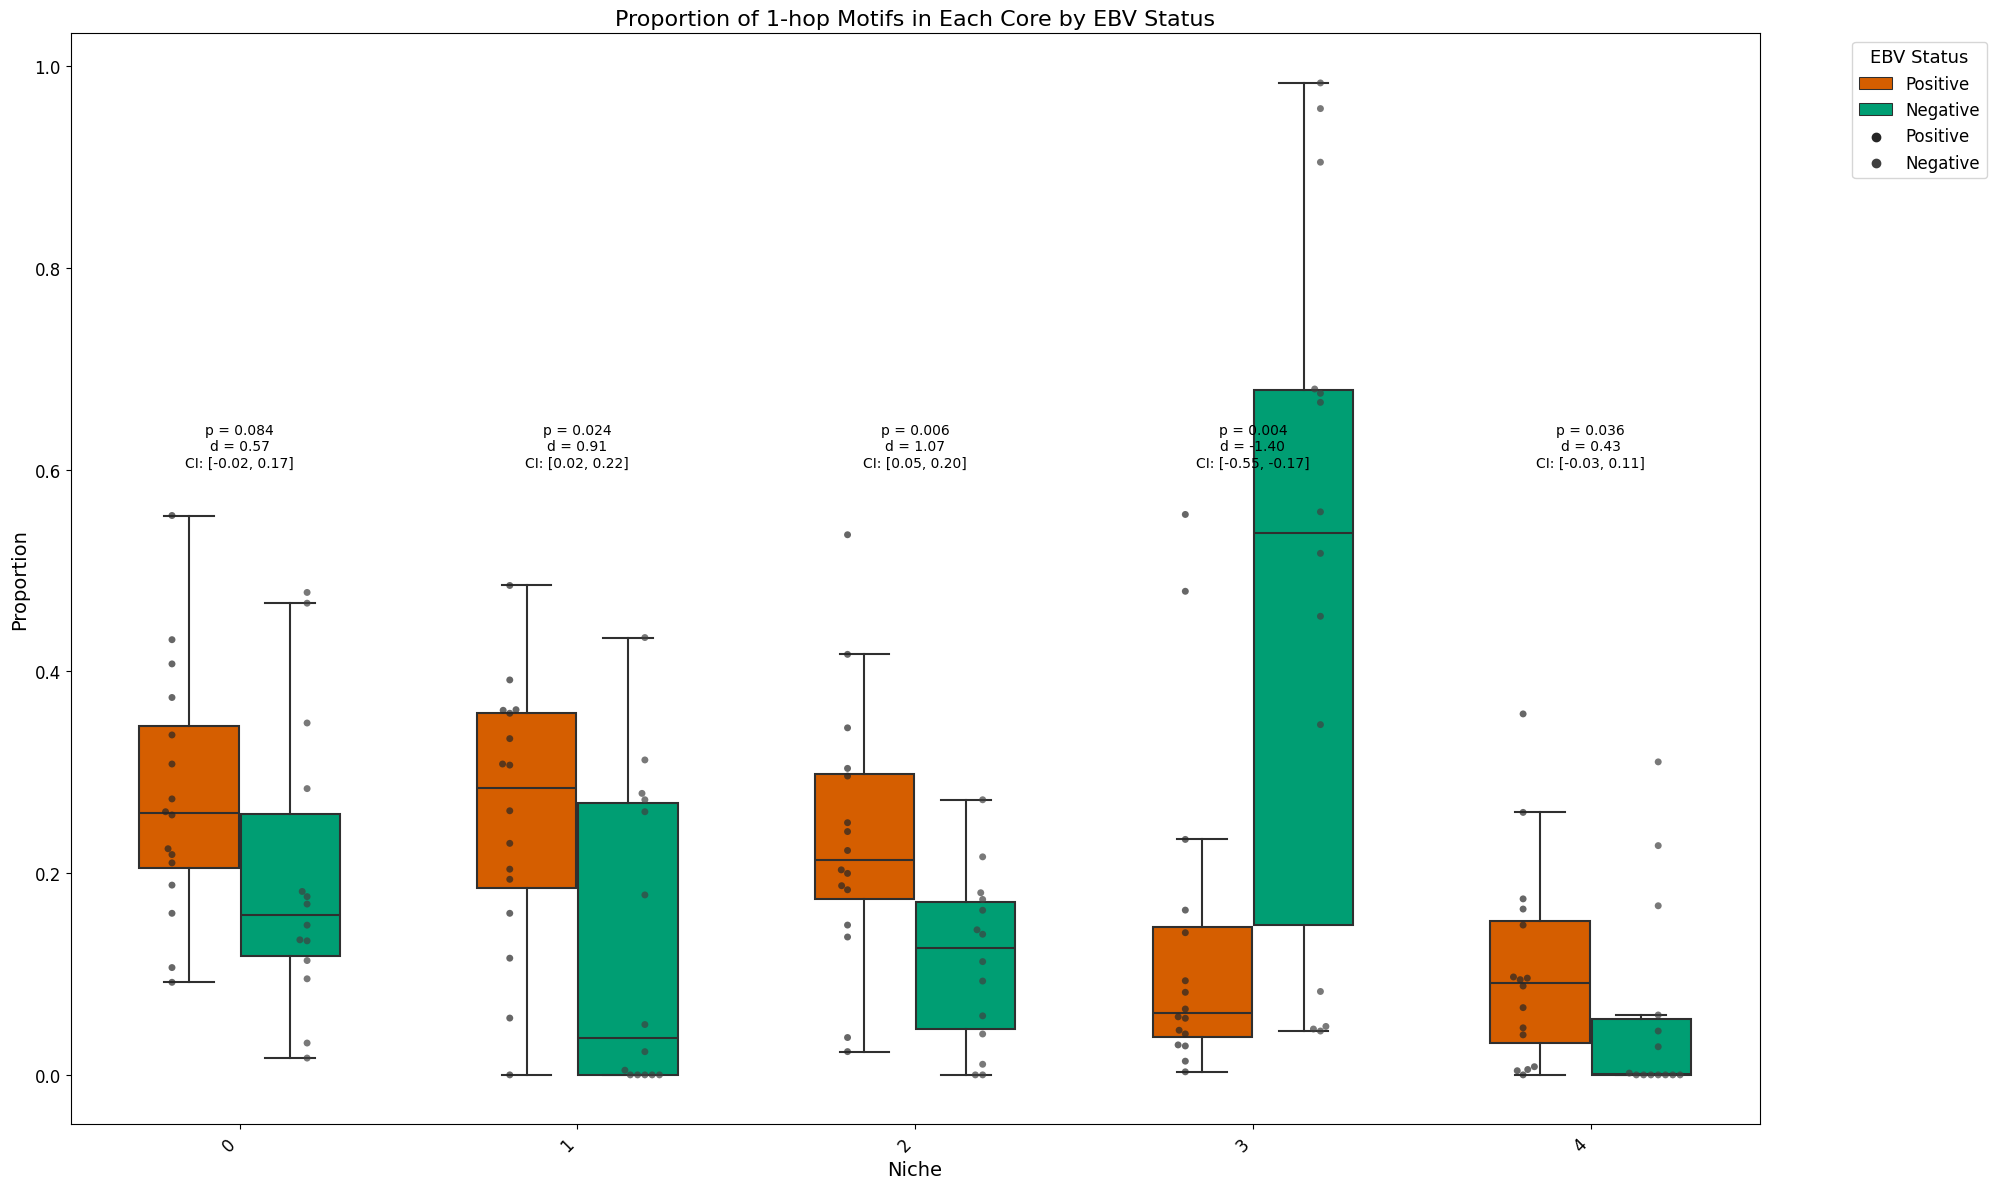

In [61]:
tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'].isin(['CD4 T'])].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'].isin(['CD4 T'])].iterrows()]})

test = pd.concat([cell_count.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

test
# Calculate proportions
props = test.groupby(['Niche', 'ebv_status']).size().unstack(fill_value=0)
props = props.div(props.sum(axis=1), axis=0)

# Reorder columns to have 'Positive' first
props = props[['Positive', 'Negative']]

color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Create the dodged bar plot with custom colors
ax = props.plot(kind='bar', figsize=(12, 6), width=0.8, color=[color_palette['Positive'], color_palette['Negative']])

# Customize the plot
plt.title('Proportion of EBV Status in Each 1-hop Motif')
plt.xlabel('Niche')
plt.ylabel('Proportion')
plt.legend(title='EBV Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.savefig('../output/hop_analysis_112524/plots/1_hop_compose_ROI.pdf')

plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats import bootstrap

# Calculate proportions
test['count'] = 1
proportions = test.groupby(['coreName', 'ebv_status', 'Niche'])['count'].sum().unstack(level='Niche').fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

# Melt the dataframe
proportions_melted = proportions.reset_index().melt(id_vars=['coreName', 'ebv_status'], 
                                                    var_name='Niche', value_name='Proportion')

proportions_melted = proportions_melted.dropna()

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"
    
color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

plt.figure(figsize=(20, 12))

ax = sns.boxplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
                 width=0.6, palette=color_palette, saturation=1.0, showfliers = False)

sns.swarmplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7)


niches = proportions_melted['Niche'].unique()
for i, niche in enumerate(niches):
    niche_data = proportions_melted[proportions_melted['Niche'] == niche]
    ebv_pos = niche_data[niche_data['ebv_status'] == 'Positive']['Proportion']
    ebv_neg = niche_data[niche_data['ebv_status'] == 'Negative']['Proportion']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, 0.6, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Proportion of 1-hop Motifs in Each Core by EBV Status', fontsize=16)
plt.xlabel('Niche', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='EBV Status', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.savefig('../output/hop_analysis_112524/plots/1_hop_in_core_by_ebv_test_ROI.pdf')
plt.show()